In [3]:
!pip install optuna -q
!pip install --upgrade datasets -q
!pip install --upgrade triton -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 32.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 20.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 10.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive') # mounting drive where files are stored

Mounted at /content/drive


In [5]:
import sys
path = "/content/drive/MyDrive/AI_Cybersecurity/Project/"
sys.path.append(path)

In [6]:
import torch
import torch.nn as nn
from torch.nn import functional as F # loading libraries
from sklearn.datasets import load_iris
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict, load_from_disk
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from contextlib import nullcontext
from utils import BPE_Tokenizer, MLP, train_model, test_model, run_inference_and_collect_results, calculate_auc_roc, plot_confusion_matrix, test_model_adversarial, run_inference_and_collect_results_adversarial, multiples_of_two

In [7]:
torch.set_float32_matmul_precision('high')

In [8]:
tokenizer = BPE_Tokenizer(directory=path+'Tokenizer')
vocab = tokenizer.vocab
vocab_size = len(vocab) + 1
print("Vocab size is", vocab_size)

Vocab size is 10007


In [9]:
tokenized_dataset = load_from_disk(path+"Datasets/FinalDataset/")

In [10]:
train_dataset = tokenized_dataset['train']
val_dataset = tokenized_dataset['validation']
test_dataset = tokenized_dataset['test']

In [11]:
batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_metadata_features = len(train_dataset['metadata'][0])
hidden_layers=[128, 256]
vector_length = 1024
dropout = 0.2
warmup_steps = 10
context_size = 256
num_epochs = 1
max_lr = 2e-4
scheduler_config = {"warmup_steps": 5,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": max_lr,
                    "min_lr": max_lr * 0.1}

In [ ]:
# Initialize the model for binary classification of class 0
model = MLP(vocab_size=vocab_size, context_size=context_size, vector_length=vector_length, hidden_layers=hidden_layers, dropout=dropout, num_metadata_features=num_metadata_features).to(device)

# Test the model with the initial untrained state and compute training loss
for batch in train_loader:
    inputs = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    metadata = batch["metadata"].to(device)
    labels = batch["label"].to(device)
    logits, _ = model(inputs, attention_mask, metadata, labels)  # Forward pass through the model
    print(logits.shape)
    break

torch.cuda.empty_cache()

loss = test_model(model, train_loader, fp16=True, device="cuda")  # Compute the loss on the training dataset
print(f"Initial Training Loss {loss:.4f}")

torch.Size([128, 2])
Initial Training Loss 0.6877


In [ ]:
def objective(trial):
    # Define hyperparameters to optimize
    vector_length = trial.suggest_categorical("vector_length", multiples_of_two(128, 1024))
    num_layers = trial.suggest_int("num_layers", 1, 5)  # Number of hidden layers
    layer_size = trial.suggest_categorical("layer_size", multiples_of_two(64, 512))  # Size of each layer
    hidden_layers = [layer_size] * num_layers  # Create a list of `num_layers`, each of size `layer_size`
    dropout = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    num_epochs = trial.suggest_int("num_epochs", 1, 5)
    lr = trial.suggest_float("lr", 1e-6, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    warmup_steps = trial.suggest_int("warmup_steps", 10, 100, step=10)
    context_size = 256

    # Create the model
    model = MLP(
        vocab_size=10240,
        vector_length=vector_length,
        context_size=context_size,
        num_metadata_features=num_metadata_features,
        hidden_layers=hidden_layers,
        dropout=dropout,
        padding_idx=tokenizer.padding_idx,
        num_classes=2,
    ).to(device)
    model = torch.compile(model)

    # Optimizer
    optimizer = model.configure_optimizers(weight_decay=weight_decay, learning_rate=lr, device_type=device)

    scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

    # Train the model
    model = train_model(
        model=model,
        train_dataloader=train_loader,
        val_dataloader=val_loader,
        num_epochs=num_epochs,
        optimizer=optimizer,
        device=device,
        fp16=True,
        log_interval=10,
        early_stopping=True,
    )

    # Evaluate on the validation set
    val_loss = test_model(model, val_loader, device, fp16=True)

    # Return the validation loss as the objective to minimize
    return val_loss

In [ ]:
# Create an Optuna study
study = optuna.create_study(direction="minimize")

# Run the optimization
study.optimize(objective, n_trials=50)

[I 2024-12-07 13:05:56,048] A new study created in memory with name: no-name-81db6dd8-94d3-40bd-bc04-356808213682


Num decayed parameter tensors: 5, with 27,275,520 parameters
Num non-decayed parameter tensors: 4, with 194 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3809, Average Validation Loss: 0.0422, Accuracy: 99.19%, Precision: 99.96%, Recall: 98.65%, F1: 0.99
Epoch 0, Average Training Loss: 0.0897, Average Validation Loss: 0.0404, Accuracy: 99.23%, Precision: 99.94%, Recall: 98.73%, F1: 0.99
Epoch 0, Average Training Loss: 0.0725, Average Validation Loss: 0.0381, Accuracy: 99.22%, Precision: 99.98%, Recall: 98.67%, F1: 0.99
Epoch 0, Average Training Loss: 0.0428, Average Validation Loss: 0.0378, Accuracy: 99.25%, Precision: 99.96%, Recall: 98.75%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0354, Average Validation Loss: 0.0405, Accuracy: 99.23%, Precision: 99.99%, Recall: 98.68%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0590, Average Validation L

[I 2024-12-07 13:07:18,864] Trial 0 finished with value: 0.04248847967482525 and parameters: {'vector_length': 1024, 'num_layers': 3, 'layer_size': 64, 'dropout': 0.30000000000000004, 'num_epochs': 1, 'lr': 0.0007064166250862515, 'weight_decay': 9.92074768822372e-05, 'warmup_steps': 80}. Best is trial 0 with value: 0.04248847967482525.
W1207 13:07:20.195000 997 torch/_dynamo/convert_frame.py:844] [0/11] torch._dynamo hit config.cache_size_limit (8)
W1207 13:07:20.195000 997 torch/_dynamo/convert_frame.py:844] [0/11]    function: 'forward' (/content/drive/MyDrive/Project/utils.py:159)
W1207 13:07:20.195000 997 torch/_dynamo/convert_frame.py:844] [0/11]    last reason: 0/1: GLOBAL_STATE changed: grad_mode 
W1207 13:07:20.195000 997 torch/_dynamo/convert_frame.py:844] [0/11] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W1207 13:07:20.195000 997 torch/_dynamo/convert_frame.py:844] [0/11] To diagnose recompilation issues, see https://pytorch.org/docs/main/torch.compiler_tr

Num decayed parameter tensors: 4, with 144,993,280 parameters
Num non-decayed parameter tensors: 3, with 1,026 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3151, Average Validation Loss: 0.0541, Accuracy: 99.19%, Precision: 99.84%, Recall: 98.76%, F1: 0.99
Epoch 0, Average Training Loss: 0.0652, Average Validation Loss: 0.0555, Accuracy: 99.21%, Precision: 99.97%, Recall: 98.66%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0474, Average Validation Loss: 0.0699, Accuracy: 99.22%, Precision: 99.99%, Recall: 98.66%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0933, Average Validation Loss: 0.0508, Accuracy: 99.28%, Precision: 99.96%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0259, Average Validation Loss: 0.0844, Accuracy: 99.01%, Precision: 100.00%, Recall: 98.29%, F1: 0.99
No significant improvement in validation loss for 1 step

[I 2024-12-07 13:08:49,186] Trial 1 finished with value: 0.031172359065542853 and parameters: {'vector_length': 1024, 'num_layers': 2, 'layer_size': 512, 'dropout': 0.30000000000000004, 'num_epochs': 4, 'lr': 0.0004224978088566638, 'weight_decay': 5.832566444236443e-05, 'warmup_steps': 80}. Best is trial 1 with value: 0.031172359065542853.


Num decayed parameter tensors: 6, with 27,279,616 parameters
Num non-decayed parameter tensors: 5, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6848, Average Validation Loss: 0.6734, Accuracy: 63.50%, Precision: 100.00%, Recall: 61.04%, F1: 0.76
Epoch 0, Average Training Loss: 0.6508, Average Validation Loss: 0.6219, Accuracy: 80.55%, Precision: 100.00%, Recall: 74.62%, F1: 0.85
Epoch 0, Average Training Loss: 0.6285, Average Validation Loss: 0.5770, Accuracy: 89.66%, Precision: 100.00%, Recall: 84.69%, F1: 0.92
Epoch 0, Average Training Loss: 0.5944, Average Validation Loss: 0.5409, Accuracy: 93.37%, Precision: 100.00%, Recall: 89.61%, F1: 0.95
Epoch 0, Average Training Loss: 0.5827, Average Validation Loss: 0.5152, Accuracy: 94.70%, Precision: 100.00%, Recall: 91.52%, F1: 0.96
Epoch 0, Average Training Loss: 0.5538, Average Validation Loss: 0.4874, Accuracy: 95.84%, Precision: 100.00%, Recall: 93.22%, F1: 0.96
Epoch 0, Average Training Loss: 0.5428, A

[I 2024-12-07 13:15:12,308] Trial 2 finished with value: 0.033903507590042174 and parameters: {'vector_length': 1024, 'num_layers': 4, 'layer_size': 64, 'dropout': 0.5, 'num_epochs': 5, 'lr': 1.955213376771193e-05, 'weight_decay': 3.880830286912796e-06, 'warmup_steps': 80}. Best is trial 1 with value: 0.031172359065542853.


Num decayed parameter tensors: 3, with 18,114,688 parameters
Num non-decayed parameter tensors: 2, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6426, Average Validation Loss: 0.5888, Accuracy: 61.79%, Precision: 100.00%, Recall: 59.95%, F1: 0.75
Epoch 0, Average Training Loss: 0.5519, Average Validation Loss: 0.4983, Accuracy: 82.75%, Precision: 100.00%, Recall: 76.83%, F1: 0.87
Epoch 0, Average Training Loss: 0.4582, Average Validation Loss: 0.4178, Accuracy: 95.45%, Precision: 99.99%, Recall: 92.64%, F1: 0.96
Epoch 0, Average Training Loss: 0.3805, Average Validation Loss: 0.3442, Accuracy: 96.24%, Precision: 99.99%, Recall: 93.84%, F1: 0.97
Epoch 0, Average Training Loss: 0.3132, Average Validation Loss: 0.2806, Accuracy: 97.33%, Precision: 99.99%, Recall: 95.54%, F1: 0.98
Epoch 0, Average Training Loss: 0.2531, Average Validation Loss: 0.2257, Accuracy: 98.16%, Precision: 99.98%, Recall: 96.91%, F1: 0.98
Epoch 0, Average Training Loss: 0.2000, Avera

[I 2024-12-07 13:19:08,585] Trial 3 finished with value: 0.024416507828376583 and parameters: {'vector_length': 128, 'num_layers': 1, 'layer_size': 512, 'dropout': 0.1, 'num_epochs': 4, 'lr': 6.669732474227777e-06, 'weight_decay': 5.895154573238439e-06, 'warmup_steps': 90}. Best is trial 3 with value: 0.024416507828376583.


Num decayed parameter tensors: 6, with 73,165,312 parameters
Num non-decayed parameter tensors: 5, with 2,050 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6896, Average Validation Loss: 0.6856, Accuracy: 58.09%, Precision: 100.00%, Recall: 57.71%, F1: 0.73
Epoch 0, Average Training Loss: 0.6831, Average Validation Loss: 0.6755, Accuracy: 59.39%, Precision: 100.00%, Recall: 58.48%, F1: 0.74
Epoch 0, Average Training Loss: 0.6688, Average Validation Loss: 0.6587, Accuracy: 61.34%, Precision: 100.00%, Recall: 59.67%, F1: 0.75
Epoch 0, Average Training Loss: 0.6477, Average Validation Loss: 0.6304, Accuracy: 62.71%, Precision: 100.00%, Recall: 60.53%, F1: 0.75
Epoch 0, Average Training Loss: 0.6124, Average Validation Loss: 0.5891, Accuracy: 64.40%, Precision: 100.00%, Recall: 61.64%, F1: 0.76
Epoch 0, Average Training Loss: 0.5685, Average Validation Loss: 0.5372, Accuracy: 68.61%, Precision: 100.00%, Recall: 64.56%, F1: 0.78
Epoch 0, Average Training Loss: 0.5106,

[I 2024-12-07 13:22:25,949] Trial 4 finished with value: 0.029569815636637645 and parameters: {'vector_length': 512, 'num_layers': 4, 'layer_size': 512, 'dropout': 0.30000000000000004, 'num_epochs': 3, 'lr': 3.862291825859076e-06, 'weight_decay': 1.7162322879412439e-06, 'warmup_steps': 50}. Best is trial 3 with value: 0.024416507828376583.


Num decayed parameter tensors: 4, with 5,528,192 parameters
Num non-decayed parameter tensors: 3, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6842, Average Validation Loss: 0.6816, Accuracy: 58.14%, Precision: 99.99%, Recall: 57.74%, F1: 0.73
Epoch 0, Average Training Loss: 0.6782, Average Validation Loss: 0.6738, Accuracy: 58.34%, Precision: 99.99%, Recall: 57.86%, F1: 0.73
Epoch 0, Average Training Loss: 0.6674, Average Validation Loss: 0.6659, Accuracy: 58.59%, Precision: 99.99%, Recall: 58.01%, F1: 0.73
Epoch 0, Average Training Loss: 0.6634, Average Validation Loss: 0.6578, Accuracy: 58.99%, Precision: 99.99%, Recall: 58.24%, F1: 0.74
Epoch 0, Average Training Loss: 0.6567, Average Validation Loss: 0.6495, Accuracy: 59.65%, Precision: 99.99%, Recall: 58.64%, F1: 0.74
Epoch 0, Average Training Loss: 0.6486, Average Validation Loss: 0.6408, Accuracy: 60.60%, Precision: 99.99%, Recall: 59.21%, F1: 0.74
Epoch 0, Average Training Loss: 0.6332, Average 

[I 2024-12-07 13:32:43,917] Trial 5 finished with value: 0.03322683662377499 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 128, 'dropout': 0.1, 'num_epochs': 1, 'lr': 2.661363222780671e-06, 'weight_decay': 7.419077258137341e-05, 'warmup_steps': 60}. Best is trial 3 with value: 0.024416507828376583.


Num decayed parameter tensors: 4, with 144,993,280 parameters
Num non-decayed parameter tensors: 3, with 1,026 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2518, Average Validation Loss: 0.0543, Accuracy: 99.05%, Precision: 99.99%, Recall: 98.38%, F1: 0.99
Epoch 0, Average Training Loss: 0.0576, Average Validation Loss: 0.0599, Accuracy: 99.12%, Precision: 99.99%, Recall: 98.50%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0584, Average Validation Loss: 0.0450, Accuracy: 99.20%, Precision: 99.99%, Recall: 98.64%, F1: 0.99
Epoch 0, Average Training Loss: 0.0549, Average Validation Loss: 0.0312, Accuracy: 99.32%, Precision: 99.86%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0318, Average Validation Loss: 0.0486, Accuracy: 99.13%, Precision: 99.99%, Recall: 98.52%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0666, Average Validatio

[I 2024-12-07 13:34:40,239] Trial 6 finished with value: 0.022466586580550348 and parameters: {'vector_length': 1024, 'num_layers': 2, 'layer_size': 512, 'dropout': 0.4, 'num_epochs': 4, 'lr': 0.00010074901065788951, 'weight_decay': 3.005640827982952e-06, 'warmup_steps': 80}. Best is trial 6 with value: 0.022466586580550348.


Num decayed parameter tensors: 4, with 3,415,424 parameters
Num non-decayed parameter tensors: 3, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6959, Average Validation Loss: 0.6915, Accuracy: 43.45%, Precision: 2.07%, Recall: 68.72%, F1: 0.04
Epoch 0, Average Training Loss: 0.6888, Average Validation Loss: 0.6866, Accuracy: 47.77%, Precision: 10.26%, Recall: 86.60%, F1: 0.18
Epoch 0, Average Training Loss: 0.6865, Average Validation Loss: 0.6816, Accuracy: 60.66%, Precision: 34.16%, Recall: 92.06%, F1: 0.50
Epoch 0, Average Training Loss: 0.6800, Average Validation Loss: 0.6768, Accuracy: 78.29%, Precision: 67.33%, Recall: 92.70%, F1: 0.78
Epoch 0, Average Training Loss: 0.6734, Average Validation Loss: 0.6721, Accuracy: 89.24%, Precision: 89.19%, Recall: 91.77%, F1: 0.90
Epoch 0, Average Training Loss: 0.6696, Average Validation Loss: 0.6672, Accuracy: 92.09%, Precision: 97.77%, Recall: 89.40%, F1: 0.93
Epoch 0, Average Training Loss: 0.6651, Average V

[I 2024-12-07 13:50:05,182] Trial 7 finished with value: 0.04082007793759977 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 64, 'dropout': 0.30000000000000004, 'num_epochs': 3, 'lr': 2.0147494961887756e-06, 'weight_decay': 0.0004069819187159517, 'warmup_steps': 50}. Best is trial 6 with value: 0.022466586580550348.


Num decayed parameter tensors: 4, with 38,876,672 parameters
Num non-decayed parameter tensors: 3, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6858, Average Validation Loss: 0.6767, Accuracy: 61.95%, Precision: 99.99%, Recall: 60.05%, F1: 0.75
Epoch 0, Average Training Loss: 0.6707, Average Validation Loss: 0.6602, Accuracy: 60.85%, Precision: 100.00%, Recall: 59.36%, F1: 0.74
Epoch 0, Average Training Loss: 0.6526, Average Validation Loss: 0.6441, Accuracy: 60.82%, Precision: 100.00%, Recall: 59.34%, F1: 0.74
Epoch 0, Average Training Loss: 0.6394, Average Validation Loss: 0.6276, Accuracy: 61.42%, Precision: 100.00%, Recall: 59.72%, F1: 0.75
Epoch 0, Average Training Loss: 0.6188, Average Validation Loss: 0.6104, Accuracy: 62.47%, Precision: 100.00%, Recall: 60.38%, F1: 0.75
Epoch 0, Average Training Loss: 0.6101, Average Validation Loss: 0.5921, Accuracy: 64.01%, Precision: 100.00%, Recall: 61.37%, F1: 0.76
Epoch 0, Average Training Loss: 0.5864, Av

[I 2024-12-07 13:57:32,604] Trial 8 finished with value: 0.0325535055350613 and parameters: {'vector_length': 512, 'num_layers': 2, 'layer_size': 256, 'dropout': 0.30000000000000004, 'num_epochs': 5, 'lr': 1.1028092257874397e-06, 'weight_decay': 6.448004353665794e-06, 'warmup_steps': 70}. Best is trial 6 with value: 0.022466586580550348.


Num decayed parameter tensors: 3, with 38,811,136 parameters
Num non-decayed parameter tensors: 2, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2916, Average Validation Loss: 0.0492, Accuracy: 98.97%, Precision: 99.81%, Recall: 98.41%, F1: 0.99
Epoch 0, Average Training Loss: 0.0499, Average Validation Loss: 0.0304, Accuracy: 99.28%, Precision: 99.87%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0654, Average Validation Loss: 0.0364, Accuracy: 99.29%, Precision: 99.64%, Recall: 99.12%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0428, Average Validation Loss: 0.0293, Accuracy: 99.37%, Precision: 99.96%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0296, Average Validation Loss: 0.0268, Accuracy: 99.39%, Precision: 99.93%, Recall: 99.02%, F1: 0.99
Epoch 0, Average Training Loss: 0.0319, Average Validation Loss: 0.0255, Accuracy: 99.39%, Precision: 99.87%, Recall: 99.

[I 2024-12-07 13:59:31,643] Trial 9 finished with value: 0.0194498984545872 and parameters: {'vector_length': 512, 'num_layers': 1, 'layer_size': 256, 'dropout': 0.4, 'num_epochs': 3, 'lr': 5.117893851479622e-05, 'weight_decay': 1.6578123999204082e-05, 'warmup_steps': 100}. Best is trial 9 with value: 0.0194498984545872.


Num decayed parameter tensors: 7, with 19,674,368 parameters
Num non-decayed parameter tensors: 6, with 1,282 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 2.1315, Average Validation Loss: 0.2339, Accuracy: 91.50%, Precision: 100.00%, Recall: 87.06%, F1: 0.93
Epoch 0, Average Training Loss: 0.3247, Average Validation Loss: 0.0986, Accuracy: 97.90%, Precision: 97.05%, Recall: 99.26%, F1: 0.98
Epoch 0, Average Training Loss: 0.2418, Average Validation Loss: 0.0761, Accuracy: 99.17%, Precision: 99.96%, Recall: 98.61%, F1: 0.99
Epoch 0, Average Training Loss: 0.2364, Average Validation Loss: 0.0716, Accuracy: 98.42%, Precision: 100.00%, Recall: 97.32%, F1: 0.99
Epoch 0, Average Training Loss: 0.2001, Average Validation Loss: 0.0531, Accuracy: 99.29%, Precision: 99.95%, Recall: 98.82%, F1: 0.99
Epoch 0, Average Training Loss: 0.1582, Average Validation Loss: 0.0660, Accuracy: 99.27%, Precision: 99.90%, Recall: 98.84%, F1: 0.99
No significant improvement in validation lo

[I 2024-12-07 14:01:02,584] Trial 10 finished with value: 0.04608979498420062 and parameters: {'vector_length': 256, 'num_layers': 5, 'layer_size': 256, 'dropout': 0.5, 'num_epochs': 2, 'lr': 0.009539626015101757, 'weight_decay': 1.908338715152352e-05, 'warmup_steps': 20}. Best is trial 9 with value: 0.0194498984545872.


Num decayed parameter tensors: 3, with 38,811,136 parameters
Num non-decayed parameter tensors: 2, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2105, Average Validation Loss: 0.0456, Accuracy: 99.17%, Precision: 99.93%, Recall: 98.63%, F1: 0.99
Epoch 0, Average Training Loss: 0.0690, Average Validation Loss: 0.0339, Accuracy: 99.14%, Precision: 99.50%, Recall: 99.01%, F1: 0.99
Epoch 0, Average Training Loss: 0.0375, Average Validation Loss: 0.0328, Accuracy: 99.22%, Precision: 99.61%, Recall: 99.04%, F1: 0.99
Epoch 0, Average Training Loss: 0.0408, Average Validation Loss: 0.0475, Accuracy: 99.24%, Precision: 99.97%, Recall: 98.72%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0363, Average Validation Loss: 0.0326, Accuracy: 99.30%, Precision: 99.92%, Recall: 98.88%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0356, Average Validation L

[I 2024-12-07 14:02:01,215] Trial 11 finished with value: 0.02907759473734611 and parameters: {'vector_length': 512, 'num_layers': 1, 'layer_size': 256, 'dropout': 0.4, 'num_epochs': 3, 'lr': 7.314711553205775e-05, 'weight_decay': 1.0458197834839022e-06, 'warmup_steps': 100}. Best is trial 9 with value: 0.0194498984545872.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3267, Average Validation Loss: 0.0744, Accuracy: 99.02%, Precision: 99.70%, Recall: 98.61%, F1: 0.99
Epoch 0, Average Training Loss: 0.0521, Average Validation Loss: 0.0320, Accuracy: 99.25%, Precision: 99.87%, Recall: 98.84%, F1: 0.99
Epoch 0, Average Training Loss: 0.0296, Average Validation Loss: 0.0283, Accuracy: 99.30%, Precision: 99.93%, Recall: 98.86%, F1: 0.99
Epoch 0, Average Training Loss: 0.0456, Average Validation Loss: 0.0261, Accuracy: 99.31%, Precision: 99.92%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0331, Average Validation Loss: 0.0283, Accuracy: 99.29%, Precision: 99.99%, Recall: 98.79%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0364, Average Validation Loss: 0.0240, Accuracy: 99.37%, Precision: 99.98%, Recall: 98.

[I 2024-12-07 14:04:33,516] Trial 12 finished with value: 0.014669710158911609 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 4, 'lr': 7.089012646046724e-05, 'weight_decay': 1.667488806698983e-05, 'warmup_steps': 100}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4636, Average Validation Loss: 0.2231, Accuracy: 98.64%, Precision: 99.82%, Recall: 97.84%, F1: 0.99
Epoch 0, Average Training Loss: 0.1316, Average Validation Loss: 0.0552, Accuracy: 99.15%, Precision: 99.84%, Recall: 98.69%, F1: 0.99
Epoch 0, Average Training Loss: 0.0722, Average Validation Loss: 0.0359, Accuracy: 99.28%, Precision: 99.79%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0437, Average Validation Loss: 0.0297, Accuracy: 99.30%, Precision: 99.94%, Recall: 98.84%, F1: 0.99
Epoch 0, Average Training Loss: 0.0323, Average Validation Loss: 0.0285, Accuracy: 99.31%, Precision: 99.99%, Recall: 98.82%, F1: 0.99
Epoch 0, Average Training Loss: 0.0340, Average Validation Loss: 0.0256, Accuracy: 99.39%, Precision: 99.93%, Recall: 99.01%, F1: 0.99
Epoch 0, Average Training Loss: 0.0254, Average

[I 2024-12-07 14:07:20,201] Trial 13 finished with value: 0.017031838944357995 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 2, 'lr': 4.197562926034612e-05, 'weight_decay': 2.021135314698852e-05, 'warmup_steps': 100}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3412, Average Validation Loss: 0.0378, Accuracy: 99.13%, Precision: 99.73%, Recall: 98.75%, F1: 0.99
Epoch 0, Average Training Loss: 0.0178, Average Validation Loss: 0.0415, Accuracy: 99.25%, Precision: 99.99%, Recall: 98.72%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0435, Average Validation Loss: 0.0289, Accuracy: 99.36%, Precision: 99.85%, Recall: 99.03%, F1: 0.99
Epoch 0, Average Training Loss: 0.0491, Average Validation Loss: 0.0393, Accuracy: 99.32%, Precision: 99.96%, Recall: 98.87%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0668, Average Validation Loss: 0.0280, Accuracy: 99.30%, Precision: 99.57%, Recall: 99.20%, F1: 0.99
No significant improvement in validation loss for 2 step(s).

[I 2024-12-07 14:09:18,940] Trial 14 finished with value: 0.01532584475919705 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 2, 'lr': 0.00040179548711394747, 'weight_decay': 0.0002419274179983588, 'warmup_steps': 20}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 5, with 11,049,728 parameters
Num non-decayed parameter tensors: 4, with 386 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3069, Average Validation Loss: 0.0450, Accuracy: 99.11%, Precision: 99.77%, Recall: 98.69%, F1: 0.99
Epoch 0, Average Training Loss: 0.0292, Average Validation Loss: 0.0837, Accuracy: 99.13%, Precision: 99.99%, Recall: 98.51%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0801, Average Validation Loss: 0.0375, Accuracy: 99.20%, Precision: 99.56%, Recall: 99.05%, F1: 0.99
Epoch 0, Average Training Loss: 0.0352, Average Validation Loss: 0.0291, Accuracy: 99.30%, Precision: 99.93%, Recall: 98.87%, F1: 0.99
Epoch 0, Average Training Loss: 0.0398, Average Validation Loss: 0.0282, Accuracy: 99.36%, Precision: 99.91%, Recall: 98.97%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0387, Average Validation L

[I 2024-12-07 14:11:03,651] Trial 15 finished with value: 0.01904302129547137 and parameters: {'vector_length': 256, 'num_layers': 3, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 2, 'lr': 0.000583559567804935, 'weight_decay': 0.0009334807707068941, 'warmup_steps': 10}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 1.2822, Average Validation Loss: 0.1080, Accuracy: 97.30%, Precision: 99.95%, Recall: 95.53%, F1: 0.98
Epoch 0, Average Training Loss: 0.0567, Average Validation Loss: 0.0542, Accuracy: 99.31%, Precision: 99.94%, Recall: 98.86%, F1: 0.99
Epoch 0, Average Training Loss: 0.0757, Average Validation Loss: 0.0857, Accuracy: 97.05%, Precision: 95.42%, Recall: 99.41%, F1: 0.97
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0549, Average Validation Loss: 0.0610, Accuracy: 99.13%, Precision: 100.00%, Recall: 98.50%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0320, Average Validation Loss: 0.0322, Accuracy: 99.33%, Precision: 99.98%, Recall: 98.87%, F1: 0.99
Epoch 0, Average Training Loss: 0.0374, Average Validation 

[I 2024-12-07 14:12:34,255] Trial 16 finished with value: 0.023839316443175176 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 4, 'lr': 0.003022139155867, 'weight_decay': 0.00021472756867181697, 'warmup_steps': 30}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 5, with 11,049,728 parameters
Num non-decayed parameter tensors: 4, with 386 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4444, Average Validation Loss: 0.1197, Accuracy: 98.89%, Precision: 99.70%, Recall: 98.38%, F1: 0.99
Epoch 0, Average Training Loss: 0.0925, Average Validation Loss: 0.0353, Accuracy: 99.11%, Precision: 99.56%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0274, Average Validation Loss: 0.0415, Accuracy: 99.25%, Precision: 99.93%, Recall: 98.78%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0499, Average Validation Loss: 0.0318, Accuracy: 99.33%, Precision: 99.84%, Recall: 99.00%, F1: 0.99
Epoch 0, Average Training Loss: 0.0455, Average Validation Loss: 0.0265, Accuracy: 99.39%, Precision: 99.86%, Recall: 99.07%, F1: 0.99
Epoch 0, Average Training Loss: 0.0356, Average Validation Loss: 0.0259, Accuracy: 99.44%, Precision: 99.96%, Recall: 99.

[I 2024-12-07 14:15:03,331] Trial 17 finished with value: 0.022779144684003817 and parameters: {'vector_length': 256, 'num_layers': 3, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 2, 'lr': 0.0002296252897623957, 'weight_decay': 0.00017702652016480134, 'warmup_steps': 30}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 6, with 11,066,112 parameters
Num non-decayed parameter tensors: 5, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3073, Average Validation Loss: 0.0781, Accuracy: 99.19%, Precision: 99.91%, Recall: 98.70%, F1: 0.99
Epoch 0, Average Training Loss: 0.0890, Average Validation Loss: 0.0888, Accuracy: 99.11%, Precision: 100.00%, Recall: 98.47%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0776, Average Validation Loss: 0.0306, Accuracy: 99.27%, Precision: 100.00%, Recall: 98.73%, F1: 0.99
Epoch 0, Average Training Loss: 0.0387, Average Validation Loss: 0.0327, Accuracy: 99.17%, Precision: 100.00%, Recall: 98.57%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0376, Average Validation Loss: 0.0310, Accuracy: 99.36%, Precision: 99.81%, Recall: 99.08%, F1: 0.99
No significant improvement in validation loss for 2 step(

[I 2024-12-07 14:15:59,300] Trial 18 finished with value: 0.02748761998137107 and parameters: {'vector_length': 256, 'num_layers': 4, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 1, 'lr': 0.00131577661933806, 'weight_decay': 3.394059146969969e-05, 'warmup_steps': 30}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5786, Average Validation Loss: 0.4601, Accuracy: 75.63%, Precision: 100.00%, Recall: 70.12%, F1: 0.82
Epoch 0, Average Training Loss: 0.3648, Average Validation Loss: 0.2663, Accuracy: 96.92%, Precision: 99.87%, Recall: 95.00%, F1: 0.97
Epoch 0, Average Training Loss: 0.2046, Average Validation Loss: 0.1378, Accuracy: 98.69%, Precision: 99.83%, Recall: 97.93%, F1: 0.99
Epoch 0, Average Training Loss: 0.1092, Average Validation Loss: 0.0771, Accuracy: 99.13%, Precision: 99.86%, Recall: 98.64%, F1: 0.99
Epoch 0, Average Training Loss: 0.0623, Average Validation Loss: 0.0515, Accuracy: 99.21%, Precision: 99.97%, Recall: 98.67%, F1: 0.99
Epoch 0, Average Training Loss: 0.0427, Average Validation Loss: 0.0403, Accuracy: 99.27%, Precision: 99.96%, Recall: 98.77%, F1: 0.99
Epoch 0, Average Training Loss: 0.0439, Averag

[I 2024-12-07 14:18:42,047] Trial 19 finished with value: 0.02134743867995771 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.1, 'num_epochs': 5, 'lr': 1.6399851319818785e-05, 'weight_decay': 0.0008547931781092403, 'warmup_steps': 40}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 7, with 11,082,496 parameters
Num non-decayed parameter tensors: 6, with 642 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6774, Average Validation Loss: 0.6372, Accuracy: 78.28%, Precision: 100.00%, Recall: 72.48%, F1: 0.84
Epoch 0, Average Training Loss: 0.5865, Average Validation Loss: 0.4701, Accuracy: 88.40%, Precision: 100.00%, Recall: 83.13%, F1: 0.91
Epoch 0, Average Training Loss: 0.4415, Average Validation Loss: 0.2930, Accuracy: 96.47%, Precision: 100.00%, Recall: 94.19%, F1: 0.97
Epoch 0, Average Training Loss: 0.3029, Average Validation Loss: 0.1599, Accuracy: 98.87%, Precision: 100.00%, Recall: 98.06%, F1: 0.99
Epoch 0, Average Training Loss: 0.1878, Average Validation Loss: 0.0722, Accuracy: 99.16%, Precision: 100.00%, Recall: 98.55%, F1: 0.99
Epoch 0, Average Training Loss: 0.1085, Average Validation Loss: 0.0507, Accuracy: 99.19%, Precision: 100.00%, Recall: 98.60%, F1: 0.99
Epoch 0, Average Training Loss: 0.0677, A

[I 2024-12-07 14:21:25,285] Trial 20 finished with value: 0.01678971676911051 and parameters: {'vector_length': 256, 'num_layers': 5, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 3, 'lr': 0.00017694725114909208, 'weight_decay': 0.00034878962465769353, 'warmup_steps': 10}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 7, with 11,082,496 parameters
Num non-decayed parameter tensors: 6, with 642 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6843, Average Validation Loss: 0.6524, Accuracy: 78.93%, Precision: 100.00%, Recall: 73.07%, F1: 0.84
Epoch 0, Average Training Loss: 0.6146, Average Validation Loss: 0.5200, Accuracy: 84.29%, Precision: 100.00%, Recall: 78.45%, F1: 0.88
Epoch 0, Average Training Loss: 0.5065, Average Validation Loss: 0.3702, Accuracy: 92.18%, Precision: 100.00%, Recall: 87.96%, F1: 0.94
Epoch 0, Average Training Loss: 0.3709, Average Validation Loss: 0.2597, Accuracy: 98.27%, Precision: 100.00%, Recall: 97.07%, F1: 0.99
Epoch 0, Average Training Loss: 0.2917, Average Validation Loss: 0.1521, Accuracy: 99.16%, Precision: 100.00%, Recall: 98.55%, F1: 0.99
Epoch 0, Average Training Loss: 0.1852, Average Validation Loss: 0.0577, Accuracy: 99.27%, Precision: 99.96%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0986, Av

[I 2024-12-07 14:23:19,657] Trial 21 finished with value: 0.028496713127714356 and parameters: {'vector_length': 256, 'num_layers': 5, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 3, 'lr': 0.0001565442197873896, 'weight_decay': 0.00032794151619273135, 'warmup_steps': 10}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 7, with 11,082,496 parameters
Num non-decayed parameter tensors: 6, with 642 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6724, Average Validation Loss: 0.6320, Accuracy: 57.19%, Precision: 100.00%, Recall: 57.19%, F1: 0.73
Epoch 0, Average Training Loss: 0.5588, Average Validation Loss: 0.4460, Accuracy: 65.58%, Precision: 100.00%, Recall: 62.42%, F1: 0.77
Epoch 0, Average Training Loss: 0.4326, Average Validation Loss: 0.3309, Accuracy: 94.92%, Precision: 100.00%, Recall: 91.84%, F1: 0.96
Epoch 0, Average Training Loss: 0.3583, Average Validation Loss: 0.2839, Accuracy: 98.70%, Precision: 100.00%, Recall: 97.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.3067, Average Validation Loss: 0.2249, Accuracy: 99.22%, Precision: 99.99%, Recall: 98.66%, F1: 0.99
Epoch 0, Average Training Loss: 0.2263, Average Validation Loss: 0.1109, Accuracy: 99.25%, Precision: 99.94%, Recall: 98.75%, F1: 0.99
Epoch 0, Average Training Loss: 0.1541, Ave

[I 2024-12-07 14:25:23,808] Trial 22 finished with value: 0.022012243157479208 and parameters: {'vector_length': 256, 'num_layers': 5, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 2, 'lr': 0.00022939767429758654, 'weight_decay': 0.00014693713441774308, 'warmup_steps': 20}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 6, with 11,066,112 parameters
Num non-decayed parameter tensors: 5, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3513, Average Validation Loss: 0.0682, Accuracy: 99.13%, Precision: 100.00%, Recall: 98.51%, F1: 0.99
Epoch 0, Average Training Loss: 0.0722, Average Validation Loss: 0.0504, Accuracy: 99.28%, Precision: 99.96%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0672, Average Validation Loss: 0.0391, Accuracy: 99.16%, Precision: 100.00%, Recall: 98.56%, F1: 0.99
Epoch 0, Average Training Loss: 0.0609, Average Validation Loss: 0.0479, Accuracy: 99.24%, Precision: 99.55%, Recall: 99.13%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0669, Average Validation Loss: 0.0290, Accuracy: 99.25%, Precision: 100.00%, Recall: 98.71%, F1: 0.99
Epoch 0, Average Training Loss: 0.0588, Average Validation Loss: 0.0282, Accuracy: 99.26%, Precision: 100.00%, Recall:

[I 2024-12-07 14:27:27,347] Trial 23 finished with value: 0.021711680919838112 and parameters: {'vector_length': 256, 'num_layers': 4, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 4, 'lr': 0.00164238792096478, 'weight_decay': 0.00044223529040355566, 'warmup_steps': 10}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 4, with 11,033,344 parameters
Num non-decayed parameter tensors: 3, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6427, Average Validation Loss: 0.5769, Accuracy: 64.38%, Precision: 100.00%, Recall: 61.62%, F1: 0.76
Epoch 0, Average Training Loss: 0.5142, Average Validation Loss: 0.4487, Accuracy: 71.36%, Precision: 100.00%, Recall: 66.63%, F1: 0.80
Epoch 0, Average Training Loss: 0.3961, Average Validation Loss: 0.3176, Accuracy: 93.65%, Precision: 100.00%, Recall: 90.01%, F1: 0.95
Epoch 0, Average Training Loss: 0.2889, Average Validation Loss: 0.2105, Accuracy: 97.88%, Precision: 100.00%, Recall: 96.42%, F1: 0.98
Epoch 0, Average Training Loss: 0.2263, Average Validation Loss: 0.1415, Accuracy: 98.97%, Precision: 99.96%, Recall: 98.26%, F1: 0.99
Epoch 0, Average Training Loss: 0.1694, Average Validation Loss: 0.1009, Accuracy: 99.10%, Precision: 99.98%, Recall: 98.47%, F1: 0.99
Epoch 0, Average Training Loss: 0.1474, Ave

[I 2024-12-07 14:30:14,300] Trial 24 finished with value: 0.025647011095959994 and parameters: {'vector_length': 256, 'num_layers': 2, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 3, 'lr': 1.9055631232803427e-05, 'weight_decay': 4.0946409254545506e-05, 'warmup_steps': 20}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 5, with 11,049,728 parameters
Num non-decayed parameter tensors: 4, with 386 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4303, Average Validation Loss: 0.0890, Accuracy: 98.68%, Precision: 99.93%, Recall: 97.81%, F1: 0.99
Epoch 0, Average Training Loss: 0.0969, Average Validation Loss: 0.0360, Accuracy: 99.24%, Precision: 99.88%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0703, Average Validation Loss: 0.0328, Accuracy: 99.31%, Precision: 99.90%, Recall: 98.90%, F1: 0.99
Epoch 0, Average Training Loss: 0.0300, Average Validation Loss: 0.0368, Accuracy: 99.32%, Precision: 99.98%, Recall: 98.85%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0430, Average Validation Loss: 0.0282, Accuracy: 99.39%, Precision: 99.98%, Recall: 98.97%, F1: 0.99
Epoch 0, Average Training Loss: 0.0331, Average Validation Loss: 0.0256, Accuracy: 99.43%, Precision: 99.99%, Recall: 99.

[I 2024-12-07 14:31:29,587] Trial 25 finished with value: 0.02253110275377293 and parameters: {'vector_length': 256, 'num_layers': 3, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 4, 'lr': 0.0003253782008206704, 'weight_decay': 1.058944001935151e-05, 'warmup_steps': 40}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6932, Average Validation Loss: 0.1825, Accuracy: 95.43%, Precision: 100.00%, Recall: 92.60%, F1: 0.96
Epoch 0, Average Training Loss: 0.1310, Average Validation Loss: 0.0464, Accuracy: 98.65%, Precision: 98.57%, Recall: 99.06%, F1: 0.99
Epoch 0, Average Training Loss: 0.0869, Average Validation Loss: 0.0388, Accuracy: 99.22%, Precision: 99.67%, Recall: 98.98%, F1: 0.99
Epoch 0, Average Training Loss: 0.0695, Average Validation Loss: 0.0363, Accuracy: 99.33%, Precision: 99.80%, Recall: 99.03%, F1: 0.99
Epoch 0, Average Training Loss: 0.0792, Average Validation Loss: 0.0266, Accuracy: 99.37%, Precision: 99.87%, Recall: 99.03%, F1: 0.99
Epoch 0, Average Training Loss: 0.0442, Average Validation Loss: 0.0271, Accuracy: 99.33%, Precision: 99.87%, Recall: 98.97%, F1: 0.99
No significant improvement in validation loss 

[I 2024-12-07 14:32:49,713] Trial 26 finished with value: 0.026011243844373352 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 2, 'lr': 0.0011952620506455994, 'weight_decay': 0.00011394679037211591, 'warmup_steps': 40}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 7, with 11,082,496 parameters
Num non-decayed parameter tensors: 6, with 642 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6700, Average Validation Loss: 0.5966, Accuracy: 85.40%, Precision: 100.00%, Recall: 79.66%, F1: 0.89
Epoch 0, Average Training Loss: 0.5020, Average Validation Loss: 0.3456, Accuracy: 93.53%, Precision: 100.00%, Recall: 89.84%, F1: 0.95
Epoch 0, Average Training Loss: 0.2791, Average Validation Loss: 0.1225, Accuracy: 99.13%, Precision: 99.87%, Recall: 98.64%, F1: 0.99
Epoch 0, Average Training Loss: 0.1066, Average Validation Loss: 0.0447, Accuracy: 99.25%, Precision: 99.91%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0456, Average Validation Loss: 0.0337, Accuracy: 99.27%, Precision: 99.74%, Recall: 98.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0363, Average Validation Loss: 0.0400, Accuracy: 99.32%, Precision: 99.93%, Recall: 98.90%, F1: 0.99
No significant improvement in validation loss

[I 2024-12-07 14:35:12,877] Trial 27 finished with value: 0.02323806652959713 and parameters: {'vector_length': 256, 'num_layers': 5, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 3, 'lr': 0.0001283720976899434, 'weight_decay': 0.0005525790511421569, 'warmup_steps': 60}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 5, with 3,419,520 parameters
Num non-decayed parameter tensors: 4, with 194 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6849, Average Validation Loss: 0.6711, Accuracy: 78.20%, Precision: 100.00%, Recall: 72.40%, F1: 0.84
Epoch 0, Average Training Loss: 0.6600, Average Validation Loss: 0.6347, Accuracy: 72.29%, Precision: 100.00%, Recall: 67.36%, F1: 0.81
Epoch 0, Average Training Loss: 0.6144, Average Validation Loss: 0.5722, Accuracy: 84.34%, Precision: 100.00%, Recall: 78.51%, F1: 0.88
Epoch 0, Average Training Loss: 0.5452, Average Validation Loss: 0.4816, Accuracy: 95.17%, Precision: 99.98%, Recall: 92.23%, F1: 0.96
Epoch 0, Average Training Loss: 0.4676, Average Validation Loss: 0.3855, Accuracy: 97.10%, Precision: 99.97%, Recall: 95.20%, F1: 0.98
Epoch 0, Average Training Loss: 0.4249, Average Validation Loss: 0.3082, Accuracy: 97.67%, Precision: 99.97%, Recall: 96.11%, F1: 0.98
Epoch 0, Average Training Loss: 0.3590, Avera

[I 2024-12-07 14:38:52,297] Trial 28 finished with value: 0.027808212648724785 and parameters: {'vector_length': 128, 'num_layers': 3, 'layer_size': 64, 'dropout': 0.4, 'num_epochs': 4, 'lr': 3.578355771769988e-05, 'weight_decay': 0.00025323732433674026, 'warmup_steps': 20}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 5, with 27,275,520 parameters
Num non-decayed parameter tensors: 4, with 194 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2416, Average Validation Loss: 0.0448, Accuracy: 98.73%, Precision: 98.81%, Recall: 98.97%, F1: 0.99
Epoch 0, Average Training Loss: 0.0742, Average Validation Loss: 0.0485, Accuracy: 99.13%, Precision: 99.99%, Recall: 98.52%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0353, Average Validation Loss: 0.0481, Accuracy: 99.21%, Precision: 99.99%, Recall: 98.65%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0312, Average Validation Loss: 0.0403, Accuracy: 99.28%, Precision: 99.93%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0846, Average Validation Loss: 0.0314, Accuracy: 99.31%, Precision: 99.98%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0527, Average Validation L

[I 2024-12-07 14:40:12,521] Trial 29 finished with value: 0.03171008243854787 and parameters: {'vector_length': 1024, 'num_layers': 3, 'layer_size': 64, 'dropout': 0.30000000000000004, 'num_epochs': 1, 'lr': 0.0007362923264280894, 'weight_decay': 8.744196125424576e-05, 'warmup_steps': 70}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 4, with 11,033,344 parameters
Num non-decayed parameter tensors: 3, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5359, Average Validation Loss: 0.0762, Accuracy: 99.11%, Precision: 99.86%, Recall: 98.61%, F1: 0.99
Epoch 0, Average Training Loss: 0.1003, Average Validation Loss: 0.1006, Accuracy: 99.06%, Precision: 100.00%, Recall: 98.39%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0850, Average Validation Loss: 0.0549, Accuracy: 99.26%, Precision: 99.93%, Recall: 98.79%, F1: 0.99
Epoch 0, Average Training Loss: 0.0417, Average Validation Loss: 0.0369, Accuracy: 99.32%, Precision: 99.82%, Recall: 98.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0480, Average Validation Loss: 0.0519, Accuracy: 99.27%, Precision: 99.97%, Recall: 98.78%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0467, Average Validation 

[I 2024-12-07 14:41:32,266] Trial 30 finished with value: 0.0477858893123748 and parameters: {'vector_length': 256, 'num_layers': 2, 'layer_size': 128, 'dropout': 0.5, 'num_epochs': 2, 'lr': 0.002838721773881476, 'weight_decay': 5.2791164573314764e-05, 'warmup_steps': 10}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4921, Average Validation Loss: 0.2596, Accuracy: 96.45%, Precision: 99.93%, Recall: 94.22%, F1: 0.97
Epoch 0, Average Training Loss: 0.1609, Average Validation Loss: 0.0774, Accuracy: 99.02%, Precision: 99.64%, Recall: 98.66%, F1: 0.99
Epoch 0, Average Training Loss: 0.0606, Average Validation Loss: 0.0415, Accuracy: 99.19%, Precision: 99.96%, Recall: 98.63%, F1: 0.99
Epoch 0, Average Training Loss: 0.0334, Average Validation Loss: 0.0310, Accuracy: 99.33%, Precision: 99.94%, Recall: 98.91%, F1: 0.99
Epoch 0, Average Training Loss: 0.0414, Average Validation Loss: 0.0296, Accuracy: 99.35%, Precision: 99.89%, Recall: 98.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0343, Average Validation Loss: 0.0307, Accuracy: 99.31%, Precision: 99.99%, Recall: 98.83%, F1: 0.99
No significant improvement in validation loss f

[I 2024-12-07 14:44:14,006] Trial 31 finished with value: 0.019706283251100496 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 2, 'lr': 3.517269500784435e-05, 'weight_decay': 2.3139010241272728e-05, 'warmup_steps': 90}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6195, Average Validation Loss: 0.5452, Accuracy: 63.34%, Precision: 100.00%, Recall: 60.94%, F1: 0.76
Epoch 0, Average Training Loss: 0.4785, Average Validation Loss: 0.4081, Accuracy: 90.20%, Precision: 100.00%, Recall: 85.37%, F1: 0.92
Epoch 0, Average Training Loss: 0.3640, Average Validation Loss: 0.2876, Accuracy: 96.54%, Precision: 99.96%, Recall: 94.34%, F1: 0.97
Epoch 0, Average Training Loss: 0.2507, Average Validation Loss: 0.1927, Accuracy: 97.93%, Precision: 99.94%, Recall: 96.57%, F1: 0.98
Epoch 0, Average Training Loss: 0.1714, Average Validation Loss: 0.1287, Accuracy: 98.60%, Precision: 99.93%, Recall: 97.67%, F1: 0.99
Epoch 0, Average Training Loss: 0.1245, Average Validation Loss: 0.0904, Accuracy: 99.05%, Precision: 99.93%, Recall: 98.44%, F1: 0.99
Epoch 0, Average Training Loss: 0.0852, Avera

[I 2024-12-07 14:47:09,716] Trial 32 finished with value: 0.024364689703577677 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.4, 'num_epochs': 1, 'lr': 1.0862051423820923e-05, 'weight_decay': 1.0494093510105466e-05, 'warmup_steps': 90}. Best is trial 12 with value: 0.014669710158911609.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3662, Average Validation Loss: 0.1036, Accuracy: 98.40%, Precision: 99.89%, Recall: 97.38%, F1: 0.99
Epoch 0, Average Training Loss: 0.0655, Average Validation Loss: 0.0333, Accuracy: 99.23%, Precision: 99.86%, Recall: 98.81%, F1: 0.99
Epoch 0, Average Training Loss: 0.0307, Average Validation Loss: 0.0295, Accuracy: 99.27%, Precision: 99.90%, Recall: 98.85%, F1: 0.99
Epoch 0, Average Training Loss: 0.0389, Average Validation Loss: 0.0280, Accuracy: 99.33%, Precision: 99.94%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0347, Average Validation Loss: 0.0263, Accuracy: 99.36%, Precision: 99.93%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0155, Average Validation Loss: 0.0347, Accuracy: 99.29%, Precision: 99.99%, Recall: 98.78%, F1: 0.99
No significant improvement in validation loss f

[I 2024-12-07 14:50:30,531] Trial 33 finished with value: 0.01404915655038093 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.30000000000000004, 'num_epochs': 2, 'lr': 5.880481148892314e-05, 'weight_decay': 1.0456198819636015e-05, 'warmup_steps': 100}. Best is trial 33 with value: 0.01404915655038093.


Num decayed parameter tensors: 4, with 144,993,280 parameters
Num non-decayed parameter tensors: 3, with 1,026 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.1884, Average Validation Loss: 0.0404, Accuracy: 99.18%, Precision: 99.79%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0466, Average Validation Loss: 0.0363, Accuracy: 99.28%, Precision: 99.93%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0359, Average Validation Loss: 0.0463, Accuracy: 99.20%, Precision: 99.98%, Recall: 98.65%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0442, Average Validation Loss: 0.0322, Accuracy: 99.29%, Precision: 99.89%, Recall: 98.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0613, Average Validation Loss: 0.0288, Accuracy: 99.35%, Precision: 99.97%, Recall: 98.91%, F1: 0.99
Epoch 0, Average Training Loss: 0.0322, Average Validation Loss: 0.0391, Accuracy: 99.25%, Precision: 100.00%, Recall:

[I 2024-12-07 14:51:43,584] Trial 34 finished with value: 0.026781683236461233 and parameters: {'vector_length': 1024, 'num_layers': 2, 'layer_size': 512, 'dropout': 0.30000000000000004, 'num_epochs': 3, 'lr': 7.646792764153977e-05, 'weight_decay': 1.140615903501801e-05, 'warmup_steps': 90}. Best is trial 33 with value: 0.01404915655038093.


Num decayed parameter tensors: 3, with 11,016,960 parameters
Num non-decayed parameter tensors: 2, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2749, Average Validation Loss: 0.0577, Accuracy: 98.39%, Precision: 98.11%, Recall: 99.06%, F1: 0.99
Epoch 0, Average Training Loss: 0.0197, Average Validation Loss: 0.0523, Accuracy: 99.22%, Precision: 99.92%, Recall: 98.74%, F1: 0.99
Epoch 0, Average Training Loss: 0.0855, Average Validation Loss: 0.0507, Accuracy: 99.29%, Precision: 99.95%, Recall: 98.82%, F1: 0.99
Epoch 0, Average Training Loss: 0.0355, Average Validation Loss: 0.0379, Accuracy: 99.33%, Precision: 99.91%, Recall: 98.93%, F1: 0.99
Epoch 0, Average Training Loss: 0.0499, Average Validation Loss: 0.0328, Accuracy: 99.22%, Precision: 99.50%, Recall: 99.13%, F1: 0.99
Epoch 0, Average Training Loss: 0.0445, Average Validation Loss: 0.0333, Accuracy: 99.33%, Precision: 99.90%, Recall: 98.94%, F1: 0.99
No significant improvement in validation loss f

[I 2024-12-07 14:52:58,309] Trial 35 finished with value: 0.022653540032538208 and parameters: {'vector_length': 256, 'num_layers': 1, 'layer_size': 128, 'dropout': 0.2, 'num_epochs': 5, 'lr': 0.000301922095277835, 'weight_decay': 5.7985312734793214e-06, 'warmup_steps': 70}. Best is trial 33 with value: 0.01404915655038093.


Num decayed parameter tensors: 6, with 5,560,960 parameters
Num non-decayed parameter tensors: 5, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5003, Average Validation Loss: 0.1693, Accuracy: 98.38%, Precision: 99.84%, Recall: 97.40%, F1: 0.99
Epoch 0, Average Training Loss: 0.0571, Average Validation Loss: 0.0432, Accuracy: 99.22%, Precision: 99.69%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0922, Average Validation Loss: 0.0310, Accuracy: 99.32%, Precision: 99.72%, Recall: 99.10%, F1: 0.99
Epoch 0, Average Training Loss: 0.0365, Average Validation Loss: 0.0302, Accuracy: 99.38%, Precision: 99.98%, Recall: 98.94%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0447, Average Validation Loss: 0.0249, Accuracy: 99.36%, Precision: 99.96%, Recall: 98.94%, F1: 0.99
Epoch 0, Average Training Loss: 0.0350, Average Validation Loss: 0.0325, Accuracy: 99.24%, Precision: 100.00%, Recall: 98.

[I 2024-12-07 14:55:51,552] Trial 36 finished with value: 0.01397774032745007 and parameters: {'vector_length': 128, 'num_layers': 4, 'layer_size': 128, 'dropout': 0.1, 'num_epochs': 1, 'lr': 0.0004667023685525831, 'weight_decay': 3.790633974149675e-06, 'warmup_steps': 80}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 6, with 18,901,120 parameters
Num non-decayed parameter tensors: 5, with 2,050 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2804, Average Validation Loss: 0.0840, Accuracy: 98.69%, Precision: 98.57%, Recall: 99.14%, F1: 0.99
Epoch 0, Average Training Loss: 0.2210, Average Validation Loss: 0.0632, Accuracy: 97.96%, Precision: 100.00%, Recall: 96.55%, F1: 0.98
Epoch 0, Average Training Loss: 0.0355, Average Validation Loss: 0.0401, Accuracy: 99.11%, Precision: 100.00%, Recall: 98.47%, F1: 0.99
Epoch 0, Average Training Loss: 0.0358, Average Validation Loss: 0.0375, Accuracy: 99.31%, Precision: 99.78%, Recall: 99.02%, F1: 0.99
Epoch 0, Average Training Loss: 0.0309, Average Validation Loss: 0.0385, Accuracy: 99.26%, Precision: 99.99%, Recall: 98.74%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0496, Average Validation Loss: 0.0250, Accuracy: 99.38%, Precision: 99.99%, Recall:

[I 2024-12-07 14:57:12,001] Trial 37 finished with value: 0.017645871321469345 and parameters: {'vector_length': 128, 'num_layers': 4, 'layer_size': 512, 'dropout': 0.1, 'num_epochs': 1, 'lr': 0.0007744048659258925, 'weight_decay': 2.9132315370790403e-06, 'warmup_steps': 80}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 4, with 3,415,424 parameters
Num non-decayed parameter tensors: 3, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3859, Average Validation Loss: 0.1064, Accuracy: 97.89%, Precision: 99.82%, Recall: 96.61%, F1: 0.98
Epoch 0, Average Training Loss: 0.0591, Average Validation Loss: 0.0326, Accuracy: 99.23%, Precision: 99.79%, Recall: 98.87%, F1: 0.99
Epoch 0, Average Training Loss: 0.0341, Average Validation Loss: 0.0297, Accuracy: 99.31%, Precision: 99.90%, Recall: 98.90%, F1: 0.99
Epoch 0, Average Training Loss: 0.0573, Average Validation Loss: 0.0280, Accuracy: 99.32%, Precision: 99.93%, Recall: 98.89%, F1: 0.99
Epoch 0, Average Training Loss: 0.0404, Average Validation Loss: 0.0286, Accuracy: 99.30%, Precision: 99.96%, Recall: 98.83%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0293, Average Validation Loss: 0.0276, Accuracy: 99.33%, Precision: 99.96%, Recall: 98.8

[I 2024-12-07 14:59:09,786] Trial 38 finished with value: 0.01678221602294896 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 64, 'dropout': 0.1, 'num_epochs': 1, 'lr': 0.0004127168543723412, 'weight_decay': 4.1242107280084155e-06, 'warmup_steps': 100}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 6, with 5,560,960 parameters
Num non-decayed parameter tensors: 5, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6746, Average Validation Loss: 0.6441, Accuracy: 58.76%, Precision: 100.00%, Recall: 58.10%, F1: 0.73
Epoch 0, Average Training Loss: 0.5978, Average Validation Loss: 0.5209, Accuracy: 79.04%, Precision: 100.00%, Recall: 73.18%, F1: 0.85
Epoch 0, Average Training Loss: 0.4538, Average Validation Loss: 0.3346, Accuracy: 94.84%, Precision: 99.99%, Recall: 91.73%, F1: 0.96
Epoch 0, Average Training Loss: 0.2636, Average Validation Loss: 0.1601, Accuracy: 98.91%, Precision: 99.94%, Recall: 98.18%, F1: 0.99
Epoch 0, Average Training Loss: 0.1210, Average Validation Loss: 0.0646, Accuracy: 99.22%, Precision: 99.88%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0642, Average Validation Loss: 0.0366, Accuracy: 99.28%, Precision: 99.87%, Recall: 98.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0415, Averag

[I 2024-12-07 15:01:23,339] Trial 39 finished with value: 0.017387194521221762 and parameters: {'vector_length': 128, 'num_layers': 4, 'layer_size': 128, 'dropout': 0.1, 'num_epochs': 1, 'lr': 9.293086925261736e-05, 'weight_decay': 1.8153977518245334e-06, 'warmup_steps': 90}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 4, with 18,376,832 parameters
Num non-decayed parameter tensors: 3, with 1,026 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.6834, Average Validation Loss: 0.6634, Accuracy: 61.69%, Precision: 99.99%, Recall: 59.89%, F1: 0.75
Epoch 0, Average Training Loss: 0.6463, Average Validation Loss: 0.6316, Accuracy: 60.94%, Precision: 100.00%, Recall: 59.42%, F1: 0.75
Epoch 0, Average Training Loss: 0.6175, Average Validation Loss: 0.5991, Accuracy: 62.60%, Precision: 100.00%, Recall: 60.46%, F1: 0.75
Epoch 0, Average Training Loss: 0.5874, Average Validation Loss: 0.5640, Accuracy: 66.32%, Precision: 100.00%, Recall: 62.93%, F1: 0.77
Epoch 0, Average Training Loss: 0.5445, Average Validation Loss: 0.5234, Accuracy: 71.89%, Precision: 100.00%, Recall: 67.04%, F1: 0.80
Epoch 0, Average Training Loss: 0.5066, Average Validation Loss: 0.4776, Accuracy: 84.78%, Precision: 100.00%, Recall: 78.98%, F1: 0.88
Epoch 0, Average Training Loss: 0.4527, 

[I 2024-12-07 15:05:51,181] Trial 40 finished with value: 0.02346751859059205 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 512, 'dropout': 0.30000000000000004, 'num_epochs': 1, 'lr': 6.3960962923017345e-06, 'weight_decay': 6.698426604128356e-06, 'warmup_steps': 90}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 4, with 3,415,424 parameters
Num non-decayed parameter tensors: 3, with 130 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3405, Average Validation Loss: 0.0619, Accuracy: 98.74%, Precision: 99.78%, Recall: 98.05%, F1: 0.99
Epoch 0, Average Training Loss: 0.0593, Average Validation Loss: 0.0302, Accuracy: 99.23%, Precision: 99.70%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0227, Average Validation Loss: 0.0302, Accuracy: 99.30%, Precision: 99.93%, Recall: 98.87%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0236, Average Validation Loss: 0.0302, Accuracy: 99.31%, Precision: 99.94%, Recall: 98.87%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0315, Average Validation Loss: 0.0403, Accuracy: 99.25%, Precision: 100.00%, Recall: 98.70%, F1: 0.99
No significant improvement in validation loss for 3 step(s).

[I 2024-12-07 15:06:27,435] Trial 41 finished with value: 0.03205034329203536 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 64, 'dropout': 0.1, 'num_epochs': 1, 'lr': 0.00045022820768780933, 'weight_decay': 3.961444011122995e-06, 'warmup_steps': 100}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 3, with 3,411,328 parameters
Num non-decayed parameter tensors: 2, with 66 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2298, Average Validation Loss: 0.0472, Accuracy: 98.75%, Precision: 98.86%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0502, Average Validation Loss: 0.0375, Accuracy: 99.24%, Precision: 99.99%, Recall: 98.70%, F1: 0.99
Epoch 0, Average Training Loss: 0.0241, Average Validation Loss: 0.0388, Accuracy: 99.23%, Precision: 99.96%, Recall: 98.71%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0424, Average Validation Loss: 0.0325, Accuracy: 99.18%, Precision: 99.40%, Recall: 99.16%, F1: 0.99
Epoch 0, Average Training Loss: 0.0363, Average Validation Loss: 0.0299, Accuracy: 99.34%, Precision: 99.87%, Recall: 98.99%, F1: 0.99
Epoch 0, Average Training Loss: 0.0173, Average Validation Loss: 0.0278, Accuracy: 99.27%, Precision: 99.59%, Recall: 99.14

[I 2024-12-07 15:07:57,470] Trial 42 finished with value: 0.03825575506465661 and parameters: {'vector_length': 128, 'num_layers': 1, 'layer_size': 64, 'dropout': 0.1, 'num_epochs': 1, 'lr': 0.0004206172790091552, 'weight_decay': 3.789762971939161e-06, 'warmup_steps': 100}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 3, with 3,411,328 parameters
Num non-decayed parameter tensors: 2, with 66 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5586, Average Validation Loss: 0.3935, Accuracy: 90.82%, Precision: 100.00%, Recall: 86.17%, F1: 0.93
Epoch 0, Average Training Loss: 0.2906, Average Validation Loss: 0.1764, Accuracy: 97.85%, Precision: 99.76%, Recall: 96.60%, F1: 0.98
Epoch 0, Average Training Loss: 0.1305, Average Validation Loss: 0.0848, Accuracy: 98.92%, Precision: 99.79%, Recall: 98.35%, F1: 0.99
Epoch 0, Average Training Loss: 0.0728, Average Validation Loss: 0.0531, Accuracy: 99.20%, Precision: 99.85%, Recall: 98.76%, F1: 0.99
Epoch 0, Average Training Loss: 0.0516, Average Validation Loss: 0.0403, Accuracy: 99.25%, Precision: 99.93%, Recall: 98.78%, F1: 0.99
Epoch 0, Average Training Loss: 0.0315, Average Validation Loss: 0.0349, Accuracy: 99.31%, Precision: 99.97%, Recall: 98.83%, F1: 0.99
Epoch 0, Average Training Loss: 0.0346, Average 

[I 2024-12-07 15:11:18,795] Trial 43 finished with value: 0.016905584166178832 and parameters: {'vector_length': 128, 'num_layers': 1, 'layer_size': 64, 'dropout': 0.1, 'num_epochs': 2, 'lr': 5.798780016095514e-05, 'weight_decay': 1.985426136207551e-06, 'warmup_steps': 100}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 3, with 13,635,328 parameters
Num non-decayed parameter tensors: 2, with 66 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.2539, Average Validation Loss: 0.0365, Accuracy: 99.12%, Precision: 99.76%, Recall: 98.72%, F1: 0.99
Epoch 0, Average Training Loss: 0.0336, Average Validation Loss: 0.0302, Accuracy: 99.28%, Precision: 99.87%, Recall: 98.88%, F1: 0.99
Epoch 0, Average Training Loss: 0.0255, Average Validation Loss: 0.0296, Accuracy: 99.33%, Precision: 99.91%, Recall: 98.93%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0288, Average Validation Loss: 0.0398, Accuracy: 99.26%, Precision: 99.97%, Recall: 98.75%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0686, Average Validation Loss: 0.0275, Accuracy: 99.37%, Precision: 99.90%, Recall: 99.00%, F1: 0.99
Epoch 0, Average Training Loss: 0.0341, Average Validation Lo

[I 2024-12-07 15:13:59,854] Trial 44 finished with value: 0.01701342050187491 and parameters: {'vector_length': 512, 'num_layers': 1, 'layer_size': 64, 'dropout': 0.2, 'num_epochs': 1, 'lr': 0.00012436691966422582, 'weight_decay': 1.3473532762338478e-05, 'warmup_steps': 80}. Best is trial 36 with value: 0.01397774032745007.


Num decayed parameter tensors: 4, with 9,778,304 parameters
Num non-decayed parameter tensors: 3, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4551, Average Validation Loss: 0.0473, Accuracy: 98.91%, Precision: 99.38%, Recall: 98.72%, F1: 0.99
Epoch 0, Average Training Loss: 0.0373, Average Validation Loss: 0.0387, Accuracy: 99.19%, Precision: 99.97%, Recall: 98.62%, F1: 0.99
Epoch 0, Average Training Loss: 0.0450, Average Validation Loss: 0.0303, Accuracy: 99.31%, Precision: 99.73%, Recall: 99.06%, F1: 0.99
Epoch 0, Average Training Loss: 0.0381, Average Validation Loss: 0.0323, Accuracy: 99.15%, Precision: 99.39%, Recall: 99.13%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0392, Average Validation Loss: 0.0309, Accuracy: 99.30%, Precision: 99.96%, Recall: 98.82%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0245, Average Validation Lo

[I 2024-12-07 15:16:11,874] Trial 45 finished with value: 0.013048752666627233 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 256, 'dropout': 0.1, 'num_epochs': 2, 'lr': 0.0023658868578099314, 'weight_decay': 8.523268798897845e-06, 'warmup_steps': 80}. Best is trial 45 with value: 0.013048752666627233.


Num decayed parameter tensors: 3, with 77,608,960 parameters
Num non-decayed parameter tensors: 2, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 71.1761, Average Validation Loss: 33.5571, Accuracy: 72.23%, Precision: 99.99%, Recall: 67.31%, F1: 0.80
Epoch 0, Average Training Loss: 14.7377, Average Validation Loss: 2.4502, Accuracy: 97.25%, Precision: 99.11%, Recall: 96.19%, F1: 0.98
Epoch 0, Average Training Loss: 5.1454, Average Validation Loss: 1.6659, Accuracy: 98.95%, Precision: 99.60%, Recall: 98.58%, F1: 0.99
Epoch 0, Average Training Loss: 8.7193, Average Validation Loss: 1.9891, Accuracy: 99.04%, Precision: 99.68%, Recall: 98.66%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 2.9592, Average Validation Loss: 1.2121, Accuracy: 99.13%, Precision: 99.64%, Recall: 98.84%, F1: 0.99
Epoch 0, Average Training Loss: 1.1076, Average Validation Loss: 1.1215, Accuracy: 99.14%, Precision: 99.89%, Recall: 

[I 2024-12-07 15:18:42,861] Trial 46 finished with value: 0.45194342637786994 and parameters: {'vector_length': 1024, 'num_layers': 1, 'layer_size': 256, 'dropout': 0.2, 'num_epochs': 2, 'lr': 0.007357887607414087, 'weight_decay': 8.215274840596147e-06, 'warmup_steps': 70}. Best is trial 45 with value: 0.013048752666627233.


Num decayed parameter tensors: 4, with 9,778,304 parameters
Num non-decayed parameter tensors: 3, with 514 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.4932, Average Validation Loss: 0.0453, Accuracy: 99.08%, Precision: 99.89%, Recall: 98.52%, F1: 0.99
Epoch 0, Average Training Loss: 0.0373, Average Validation Loss: 0.0318, Accuracy: 99.20%, Precision: 99.97%, Recall: 98.65%, F1: 0.99
Epoch 0, Average Training Loss: 0.0408, Average Validation Loss: 0.0521, Accuracy: 99.11%, Precision: 100.00%, Recall: 98.46%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0483, Average Validation Loss: 0.0246, Accuracy: 99.42%, Precision: 99.84%, Recall: 99.15%, F1: 0.99
Epoch 0, Average Training Loss: 0.0161, Average Validation Loss: 0.0352, Accuracy: 99.27%, Precision: 99.99%, Recall: 98.75%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0216, Average Validation L

[I 2024-12-07 15:19:52,724] Trial 47 finished with value: 0.04337844408394114 and parameters: {'vector_length': 128, 'num_layers': 2, 'layer_size': 256, 'dropout': 0.1, 'num_epochs': 2, 'lr': 0.00269777794049691, 'weight_decay': 2.481233015772333e-05, 'warmup_steps': 60}. Best is trial 45 with value: 0.013048752666627233.


Num decayed parameter tensors: 3, with 9,712,768 parameters
Num non-decayed parameter tensors: 2, with 258 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 3.5801, Average Validation Loss: 0.5047, Accuracy: 94.67%, Precision: 99.96%, Recall: 91.51%, F1: 0.96
Epoch 0, Average Training Loss: 0.4296, Average Validation Loss: 0.1039, Accuracy: 98.89%, Precision: 99.95%, Recall: 98.14%, F1: 0.99
Epoch 0, Average Training Loss: 0.0975, Average Validation Loss: 0.0435, Accuracy: 99.18%, Precision: 99.62%, Recall: 98.95%, F1: 0.99
Epoch 0, Average Training Loss: 0.0399, Average Validation Loss: 0.0396, Accuracy: 99.10%, Precision: 99.21%, Recall: 99.21%, F1: 0.99
Epoch 0, Average Training Loss: 0.0399, Average Validation Loss: 0.0381, Accuracy: 99.25%, Precision: 99.73%, Recall: 98.96%, F1: 0.99
Epoch 0, Average Training Loss: 0.0647, Average Validation Loss: 0.0507, Accuracy: 99.23%, Precision: 100.00%, Recall: 98.68%, F1: 0.99
No significant improvement in validation loss f

[I 2024-12-07 15:21:16,379] Trial 48 finished with value: 0.04708606728424481 and parameters: {'vector_length': 128, 'num_layers': 1, 'layer_size': 256, 'dropout': 0.2, 'num_epochs': 2, 'lr': 0.005861068002448314, 'weight_decay': 1.5399756401164783e-05, 'warmup_steps': 80}. Best is trial 45 with value: 0.013048752666627233.


Num decayed parameter tensors: 5, with 38,942,208 parameters
Num non-decayed parameter tensors: 4, with 770 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.3688, Average Validation Loss: 0.0653, Accuracy: 99.06%, Precision: 99.93%, Recall: 98.45%, F1: 0.99
Epoch 0, Average Training Loss: 0.0556, Average Validation Loss: 0.0405, Accuracy: 99.25%, Precision: 99.90%, Recall: 98.80%, F1: 0.99
Epoch 0, Average Training Loss: 0.0355, Average Validation Loss: 0.0322, Accuracy: 99.27%, Precision: 99.87%, Recall: 98.85%, F1: 0.99
Epoch 0, Average Training Loss: 0.0577, Average Validation Loss: 0.0422, Accuracy: 99.22%, Precision: 99.70%, Recall: 98.94%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0424, Average Validation Loss: 0.0329, Accuracy: 99.24%, Precision: 99.75%, Recall: 98.93%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0530, Average Validation L

[I 2024-12-07 15:22:34,838] Trial 49 finished with value: 0.027518042294635763 and parameters: {'vector_length': 512, 'num_layers': 3, 'layer_size': 256, 'dropout': 0.30000000000000004, 'num_epochs': 2, 'lr': 0.0011847706167414473, 'weight_decay': 8.10229568366002e-06, 'warmup_steps': 50}. Best is trial 45 with value: 0.013048752666627233.


Best hyperparameters:
vector_length: 128
num_layers: 2
layer_size: 256
dropout: 0.1
num_epochs: 2
lr: 0.0023658868578099314
weight_decay: 8.523268798897845e-06
warmup_steps: 80


In [ ]:
# Print the best hyperparameters
print("Best hyperparameters:")
for key, value in study.best_params.items():
    print(f"{key}: {value}")

vector_length: 128
num_layers: 2
layer_size: 256
dropout: 0.1
num_epochs: 2
lr: 0.0023658868578099314
weight_decay: 8.523268798897845e-06
warmup_steps: 80


In [13]:
vector_length = 128
num_layers = 2
layer_size = 256
dropout = 0.1
num_epochs = 2
lr = 0.0023658868578099314
weight_decay = 8.523268798897845e-06
warmup_steps = 80

scheduler_config = {"warmup_steps": warmup_steps,
                    "max_steps": num_epochs * len(train_loader),
                    "max_lr": lr,
                    "min_lr": lr * 0.1}

In [14]:
model = MLP(vocab_size=10240, context_size=context_size, vector_length=vector_length, hidden_layers=hidden_layers, dropout=dropout, num_metadata_features=num_metadata_features, padding_idx=tokenizer.padding_idx).to(device)
model = torch.compile(model)

optimizer = model.configure_optimizers(weight_decay=weight_decay, learning_rate=max_lr, device_type=device) # torch.optim.AdamW(model.parameters(), lr=max_lr)

model = train_model(model, train_loader, val_loader, num_epochs=num_epochs, optimizer=optimizer, device=device, fp16=True, scheduler_config=scheduler_config, log_interval=10, early_stopping=True, patience=10, improvement_threshold=0.0001)

Num decayed parameter tensors: 4, with 5,544,832 parameters
Num non-decayed parameter tensors: 3, with 386 parameters
Using fused AdamW: True
Epoch 0, Average Training Loss: 0.5399, Average Validation Loss: 0.1825, Accuracy: 98.04%, Precision: 99.85%, Recall: 96.82%, F1: 0.98
Epoch 0, Average Training Loss: 0.0651, Average Validation Loss: 0.0422, Accuracy: 99.27%, Precision: 99.90%, Recall: 98.85%, F1: 0.99
Epoch 0, Average Training Loss: 0.0627, Average Validation Loss: 0.0320, Accuracy: 99.40%, Precision: 99.90%, Recall: 99.07%, F1: 0.99
Epoch 0, Average Training Loss: 0.0583, Average Validation Loss: 0.0343, Accuracy: 99.16%, Precision: 99.62%, Recall: 98.91%, F1: 0.99
No significant improvement in validation loss for 1 step(s).
Epoch 0, Average Training Loss: 0.0686, Average Validation Loss: 0.0357, Accuracy: 99.01%, Precision: 99.18%, Recall: 99.09%, F1: 0.99
No significant improvement in validation loss for 2 step(s).
Epoch 0, Average Training Loss: 0.0396, Average Validation Lo

In [23]:
test_results = run_inference_and_collect_results(model, test_loader, device, fp16=True)
test_loss = test_model(model, test_loader, device, fp16=False)

accuracy = accuracy_score(test_results['Predicted Outputs'], test_results['True Labels']) * 100
precision = precision_score(test_results['True Labels'], test_results['Predicted Outputs'])
recall = recall_score(test_results['True Labels'], test_results['Predicted Outputs'])
f1 = f1_score(test_results['True Labels'], test_results['Predicted Outputs'])

print(f'Final Test Loss: {test_loss:.4f}')
print(f"Final Accuracy: {accuracy:.2f}%")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Final Test Loss: 0.0072
Final Accuracy: 99.82%
Precision: 1.00
Recall: 1.00
F1 Score: 1.00


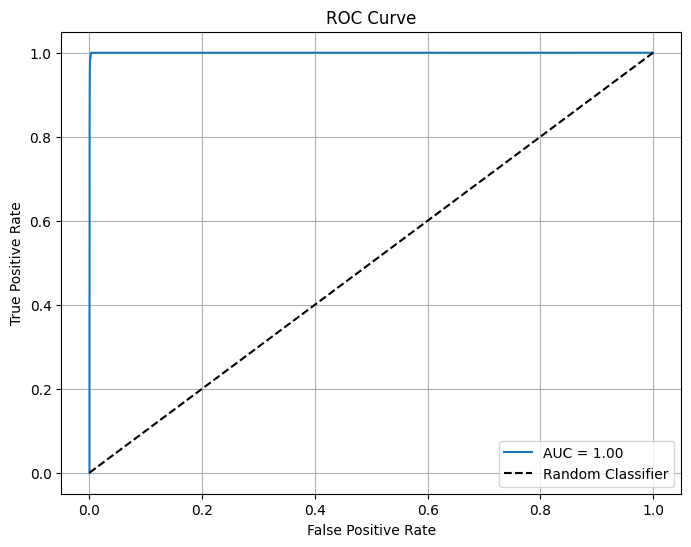

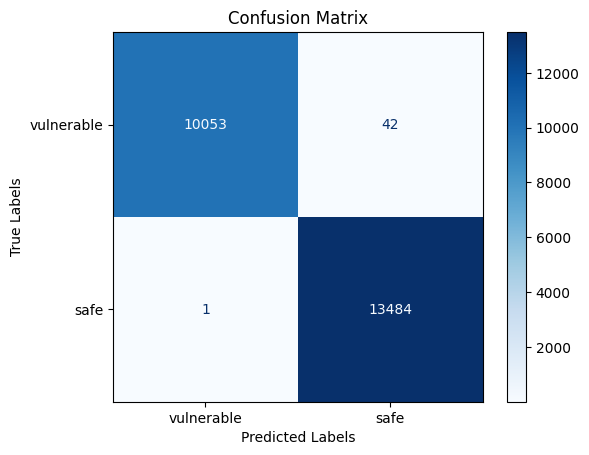

The Area Under Curve (AUC) is: 1.00


In [24]:
auc = calculate_auc_roc(model, test_loader, device)
plot_confusion_matrix(model, test_loader, device)
print(f'The Area Under Curve (AUC) is: {auc:.2f}')

In [25]:
adversarial_tokenized_dataset = load_from_disk(path+"Datasets/TransformedDataset/")

adversarial_train_dataset = adversarial_tokenized_dataset['train']
adversarial_val_dataset = adversarial_tokenized_dataset['validation']
adversarial_test_dataset = adversarial_tokenized_dataset['test']

batch_size = 128

# Prepare dataloaders for batching the data during training and evaluation
adversarial_train_loader = DataLoader(adversarial_train_dataset, batch_size=batch_size, shuffle=True)
adversarial_val_loader = DataLoader(adversarial_val_dataset, batch_size=batch_size, shuffle=True)
adversarial_test_loader = DataLoader(adversarial_test_dataset, batch_size=batch_size, shuffle=True)

In [26]:
adversarial_losses = test_model_adversarial(model, adversarial_test_loader, device, fp16=True)
adversarial_results = run_inference_and_collect_results_adversarial(model, adversarial_test_loader, device, fp16=True)

In [27]:
print("Adversarial Losses:")
print(f"Original Loss: {adversarial_losses['original_loss']:.4f}")
print(f"Similar Characters Loss: {adversarial_losses['similar_loss']:.4f}")
print(f"Case Symbols Loss: {adversarial_losses['case_symbols_loss']:.4f}")
print(f"Unicode Replacement Loss: {adversarial_losses['unicode_loss']:.4f}\n")

# Evaluate metrics for each type
for key in adversarial_results:
    predictions = adversarial_results[key]["predictions"]
    labels = adversarial_results[key]["labels"]

    accuracy = accuracy_score(labels, predictions) * 100
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    print(f"Results for {key.capitalize()} Inputs:")
    print(f"  Accuracy: {accuracy:.2f}%")
    print(f"  Precision: {precision:.2f}")
    print(f"  Recall: {recall:.2f}")
    print(f"  F1 Score: {f1:.2f}")
    print("\n")

Adversarial Losses:
Original Loss: 0.0072
Similar Characters Loss: 0.5172
Case Symbols Loss: 0.0183
Unicode Replacement Loss: 0.5848

Results for Original Inputs:
  Accuracy: 99.82%
  Precision: 1.00
  Recall: 1.00
  F1 Score: 1.00


Results for Similar Inputs:
  Accuracy: 87.28%
  Precision: 0.98
  Recall: 0.80
  F1 Score: 0.88


Results for Case symbols Inputs:
  Accuracy: 99.42%
  Precision: 1.00
  Recall: 0.99
  F1 Score: 0.99


Results for Unicode Inputs:
  Accuracy: 80.63%
  Precision: 0.99
  Recall: 0.67
  F1 Score: 0.80


